# Infrastructure hands-on: Customize your computing environment

In this notebook we will go through some steps to create and customize computing environments on the JupyterLab platform dedicated to the [Fifth Hackathon of Machine Leararning](https://agenda.infn.it/event/37650/).

In particular you will learn:
 * how to create and install a custom environment using conda;
 * how to create a custom environment running in Docker image.
 


## Introduction: the setup

The setup you are running on for this hackathon is based on a software stack combining:
 * [OpenStack](https://www.openstack.org/) (only at CNAF), creating Virtual Machines that can dynamically expand the resources made available through JupyterHub;
 * [Kubernetes](https://kubernetes.io/docs/concepts/overview/what-is-kubernetes/), defining a possibly multi-VM overlay and distributing the data through the multiple nodes via NFS;
 * [JupyterHub](https://z2jh.jupyter.org/en/stable/), defining the network and storage policy for the client applications an the authentication procedure (managed via OIDC tokens through https://iam-demo.cloud.cnaf.infn.it);
 * [JupyterLab](https://jupyter.org/), providing the web application you are interacting with
 * [Jupyter-Server-Proxy](https://github.com/jupyterhub/jupyter-server-proxy), enabling JupyterLab to define additional HTTP(s) services that can be run and exposed via the JupyterLab authentication.
 
When JupyterHub authenticates a user, it deploy a docker container (which must match some rather loose requirements in terms of software versions) and mounts persistent volumes for:
 * `private/` user data, readable and writable only for the logged-in user;
 * `shared/` user data, with read-and-write policies that can be defined by the JupyterHub administrator;
 * software, distributed through `/envs` (one day it will become based on cvmfs).
 
To you, as a developer, this means that you have three ways for matching software dependencies for your applications:
 * rely on existing software in the docker or in `/envs`;
 * have the software installed as user data (either private or shared);
 * rely (or customize) software in the docker image.
 
The order we used to list the options should be intended as defining priorities: 
 1. as long as you can rely on managed software environements, you should do that, 
 2. if you need custom environments that can be managed via conda, you should create your personal or project environment, 
 3. if conda cannot manage your dependencies, you can define your own docker image with (almost) complete freedom.
 
During the rest of the hackathon, you will use managed software environments that we prepared for you, making sure they can exploit the GPU resources properly and that they are compatible with the exercises and use cases we intend to propose. 

But now, before moving to machine learning, let's go quickly through the custmization options, to enhance your experience with the facilities made available by INFN DataCloud.



## Create a custom `conda` environment in `private/`.

Most of the usecases and examples we have prepared for the hackathon make use of relatively modern python versions (Python 3.10 or newer), but let's consider the case in which you have some old-dependencies that was not ported to Python 3.10, yet, and you need to run on Python 3.8.

You can create your custom environment, say `myenv`, in your `private` folder.


In [17]:
%%bash

conda create -yp /mlinfn/private/myenv python=3.8

Retrieving notices: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: /mlinfn/private/myenv

  added / updated specs:
    - python=3.8


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pip-23.3                   |   py38h06a4308_0         2.6 MB
    python-3.8.18              |       h955ad1f_0        25.3 MB
    setuptools-68.0.0          |   py38h06a4308_0         927 KB
    wheel-0.41.2               |   py38h06a4308_0         108 KB
    ------------------------------------------------------------
                                           Total:        28.9 MB

The following NEW packages will be INSTALLED:

  _libgcc_mutex      pkgs/main/linux-64::_libgcc_mutex-0.1-main 
  _openmp_mutex      pkgs/main/linux-64::_openmp_mutex-5.1-1_gnu 
  ca-certificates    pkgs/main/linux-64::ca-certificates-2023.08.22-h06a4308_0 
  ld_impl_linux-

Then you can popolate it with your dependencies, for example, let's install *TensorFlow* and *TensorBoard*.

Now, we will give for granted you know what *TensorFlow* is, but let's spend two lines on [TensorBoard](https://www.tensorflow.org/tensorboard).

TensorBoard is a web-based application to visualize TensorFlow operations, including metrics, losses, histograms... 

It is a much appreciated software profiling and debugging tool that we are considering here to make an example of a web-based application served through JupyterLab proxy.

> **Note.** Make sure the package `ipykernel` is also installed to enable using this kernel from Jupyter.

In [19]:
%%bash

conda run -p /mlinfn/private/myenv \
    pip install --root-user-action=ignore -q tensorflow tensorboard ipykernel

## Install the kernel via `.cloud-profile`.

If you want to use the new environment in the Jupyter notebooks, you must install its kernel in Jupyter. 
Installing a kernel is trivial, just activate the kernel and execute 
```bash
python3 -m ipykernel install --name "py38" --display-name "Python 3.8"
```

However, since you are installing the kernel in ephemeral filesystem of the docker image, you will need to re-install the kernel each time you spawn a new container. 

This can be automated by creating a file `.cloud-profile` in your private and defining there commands to be executed at each respawn.

In this case, let's create our `/mlinfn/private/.cloud-profile` loading the custom conda environment and installing the kernel with ipykernel.


In [33]:
%%writefile /mlinfn/private/.cloud-profile

conda run -p /mlinfn/private/myenv \
    python3 -m ipykernel install --name "py38" --display-name "Python 3.8"


Overwriting /mlinfn/private/.cloud-profile


Test your `.cloud-profile` to avoid locking yourself out of the JupyterLab instance trying to execute a failing script at spawning.

In [34]:
%%bash

source /mlinfn/private/.cloud-profile

Installed kernelspec py38 in /usr/local/share/jupyter/kernels/py38



## Use your custom kernel
Click on the right-top menu where the current kernel is indicated and pick your brand new kernel.

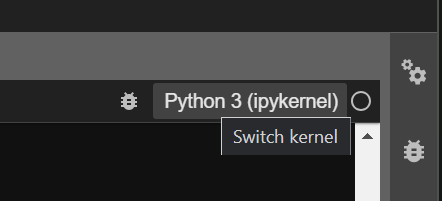

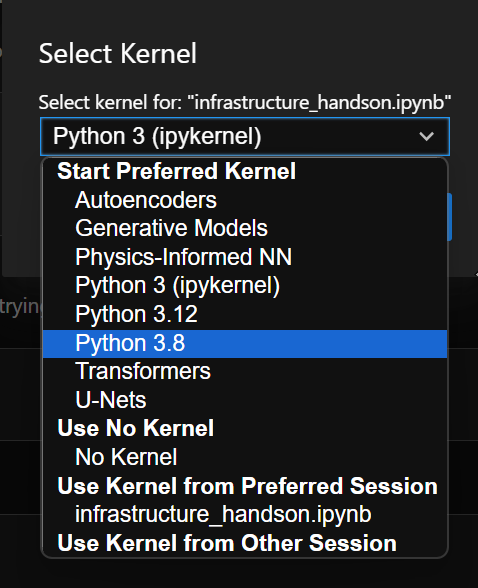

Congratulations, you have installed Python 3.8 and tensorflow in your user area.

> **Notice!** Don't expect GPU to be found properly. That requires some magic and that's why we have managed environments for the exercies.


In [1]:
import tensorflow as tf
tf.__file__

2023-11-01 13:51:53.566335: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-01 13:51:54.620415: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-01 13:51:54.625053: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 13:51:56.895722: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'/mlinfn/private/myenv/lib/python3.8/site-packages/tensorflow/__init__.py'

You can also load the *TensorBoard* extension that you have installed.

In [1]:
%load_ext tensorboard

Then to execute the TensorBoard service through the Jupyter Server Proxy you need set the environmental variable `TENSORBOARD_PROXY_URL` to `/user/<your-username>/proxy/6006/` (the training `/` is important!).

For example,
```python
import os
os.environ['TENSORBOARD_PROXY_URL'] = "/user/%(JUPYTERHUB_USER)s/proxy/6006/" % os.environ
```

Once that is done, you can run TensorBoard easily either in the a cell of your notebook or accessing the address  https://mlinfn.cloud.cnaf.infn.it/hub/user-redirect/proxy/6006/ (again, trailing `/` is important).

In [3]:
import os
os.environ['TENSORBOARD_PROXY_URL'] = "/user/%(JUPYTERHUB_USER)s/proxy/6006/" % os.environ
%tensorboard --logdir /mlinfn/logs

Reusing TensorBoard on port 6006 (pid 5931), started 0:01:39 ago. (Use '!kill 5931' to kill it.)

## Create a custom Docker environment

In some cases, creating a conda environment may not be sufficient to accomplish some specific task.

For example,
 * permanent configuration of the JupyterLab environment, developping or simply adding extensions;
 * installing software packages not available through the conda channels, but trivially installable from a package manager;
 * ... 
 
In this cases you can customize the computing environment by:
 1. creating your personal docker image;
 2. uploading it to [DockerHub](https://hub.docker.com);
 3. retrieving it through the configuration panel of the JupyterHub server. 
 
To continue with this exercise you will need an account on JupyterHub, which is free and can be obtained [here](https://hub.docker.com/signup)

> **Important Notice!** 
>
> _Do not sign-up using Google or GitHub._ 
>
> You need a unique password that can then be passed to your command-line docker interface to upload and download images.


Once you have an account, you should associate your *docker* command line to DockerHub by typing `docker login` in a terminal.

In IPython you can do the following.

In [ ]:
from getpass import getpass
username = input("Username:")
password = getpass("Password:")
!docker login --username {username} --password {password}

### Create Dockerfile

Now you can proceed with the definition of a custom docker image. 
For example, let's try to add a VS Code launcher to the JupyterLab dashboard, opening a remote instance of VS code in a new browser tab.

Create a file named, for example, `Dockerfile.vscode`. 

Inherit the Docker image from the default image for the JupyterHub environment you are using (for the hackathon, `landerlini/hackathon:v0.1b`), 
```Dockerfile
FROM landerlini/hackathon:v0.1b
```

And then edit the image as you wish, for example you can install packages from ubuntu repositories
```Dockerfile
RUN apt-get update && apt-get install --yes cowsay
```
Note the `--yes` flag indicating that the installation should assume consensus from you without asking. 

For running the installation script for [code-server, a browser-based distribution of VS code](https://github.com/coder/code-server) the [docs suggest](https://github.com/coder/code-server#getting-started) the following command: 
```bash
curl -fsSL https://code-server.dev/install.sh | sh
```

Hence, in our Dockerfile we will have:
```Dockerfile
RUN curl -fsSL https://code-server.dev/install.sh | sh
```

Finally, to add a nice launcher to the JupyterLab GUI, we need to install a three-file Python package, distributed through [GitHub](https://github.com/landerlini/jupyter_codeserver_proxy).
```Dockerfile
RUN pip install git+https://github.com/landerlini/jupyter_codeserver_proxy.git
```

---
To summarize, in this small example you have seen how to:
 * install packages from ubuntu repositories;
 * install software through installation scripts;
 * install Python package through pip.

---
Here is the Dockerfile we built together:

In [31]:
%%writefile Dockerfile.vscode

FROM landerlini/hackathon:v0.1b

RUN apt-get update && apt-get install -y cowsay

RUN curl -fsSL https://code-server.dev/install.sh | sh

RUN pip install git+https://github.com/landerlini/jupyter_codeserver_proxy.git

Overwriting Dockerfile.vscode


Let's build our image using 
```bash
docker build -t <complete_name_of_the_image_on_DockerHub> -f <input_docker_file> .
```

> **Notice!** The trailing dot is important.

The name you choose for your new docker image should begin with `<your-username>/` and end with `:<version-tag>`.

This is mandatory:
 * you are only allowed to upload images in your userspace in DockerHub, so uploading would fail if your image name does not begin with your username;
 * images must have a version tag, it can be basically whatever string, but you need to provide one.
 
 

My username in DockerHub is `landerlini`, and this is the first version of this docker image, so I will call my image
`landerlini/jhub_vscode:v1`.

In [32]:
%%bash

docker build -t landerlini/jhub_vscode:v1 -f Dockerfile.vscode .

#0 building with "default" instance using docker driver

#1 [internal] load .dockerignore
#1 transferring context: 2B done
#1 DONE 0.0s

#2 [internal] load build definition from Dockerfile.vscode
#2 transferring dockerfile: 366B done
#2 DONE 0.0s

#3 [internal] load metadata for docker.io/landerlini/hackathon:v0.1b
#3 DONE 0.4s

#4 [1/4] FROM docker.io/landerlini/hackathon:v0.1b@sha256:1b69a1be10a86833aac42b4fc5eee155f7ea5c13240d24b464e7c3f9019fe11e
#4 DONE 0.0s

#5 [2/4] RUN apt-get update && apt-get install -y cowsay
#5 CACHED

#6 [3/4] RUN curl -fsSL https://code-server.dev/install.sh | sh
#6 1.836 Ubuntu 22.04.3 LTS
#6 1.839 Installing v4.18.0 of the amd64 deb package from GitHub.
#6 1.840 
#6 1.841 + mkdir -p ~/.cache/code-server
#6 1.844 + curl -#fL -o ~/.cache/code-server/code-server_4.18.0_amd64.deb.incomplete -C - https://github.com/coder/code-server/releases/download/v4.18.0/code-server_4.18.0_amd64.deb
######################################################################## 

You can now list the docker images in your local system by typing a terminal 
```bash
docker image list
```

You should see your image appearing in the list. For example,
```
REPOSITORY                  TAG       IMAGE ID       CREATED          SIZE
landerlini/jhub_vscode      v1        bcad8ff4e4cc   47 minutes ago   6GB
```

In [33]:
%%bash 
docker image list

REPOSITORY                  TAG       IMAGE ID       CREATED          SIZE
landerlini/jhub_vscode      v1        bcad8ff4e4cc   47 minutes ago   6GB
landerlini/simple-example   v0.6c     735913074aac   14 hours ago     5.98GB
landerlini/simple-example   v0.6a     84b5d8657540   14 hours ago     5.98GB
landerlini/simple-example   v0.6b     84b5d8657540   14 hours ago     5.98GB
landerlini/simple-example   <none>    abc97e7f4d60   15 hours ago     5.98GB
landerlini/simple-example   v0.6      4d2b705bdf88   15 hours ago     5.98GB
landerlini/simple-example   v0.5a     f7aeb1f84ddc   22 hours ago     5.76GB
landerlini/simple-example   v0.5      2c31c9f46d1a   22 hours ago     5.68GB


You are now ready to upload the new image to DockerHub. 

Just type in a terminal
```bash
docker push <the_complete_name_of_the_image>
```

for example
```bash
docker push landerlini/jhub_vscode:v1
```

Docker is smart enough that will upload only the difference between the image you are inheriting from (that is already known to the service) and your new image. 
The "pieces of container" that are used to define what is already available and what is new are named *Layers*, and while pushing the image, `docker` will tell you which layers are already found on the server and which ones must be uploaded.

> **Pro tip.** When creating your docker image you should think of this mechanism and organize the command from the ones you plan to modify less frequently to those that will require to be modified or updated frequently, this saves space, time and bandwidth for both your local system and the remote DockerHub service.

In [34]:
%%bash
docker push landerlini/jhub_vscode:v1

The push refers to repository [docker.io/landerlini/jhub_vscode]
4defbca5350c: Preparing
1230b8427de3: Preparing
4a45d84d5448: Preparing
0a8ee04a0f68: Preparing
b36679cd7216: Preparing
87cfedcbc508: Preparing
9625946b852f: Preparing
f97eb7828ee4: Preparing
20784eece74a: Preparing
fd3df7be7978: Preparing
21865f9ea2f3: Preparing
bf6ac4649f7d: Preparing
76397b14f0a8: Preparing
b4326b9b9073: Preparing
bb176dc7b436: Preparing
77396e54fe4c: Preparing
ac5e708cfdc7: Preparing
1a14d8121359: Preparing
4cc3f4f99883: Preparing
54630b1f28eb: Preparing
54007f06940e: Preparing
4d7269ca293a: Preparing
48ec5760f944: Preparing
9f2a4de0a3e3: Preparing
77086d0f4c52: Preparing
ca927e644b5d: Preparing
01d4e4b4f381: Preparing
9625946b852f: Waiting
f97eb7828ee4: Waiting
20784eece74a: Waiting
9f2a4de0a3e3: Waiting
54630b1f28eb: Waiting
54007f06940e: Waiting
77086d0f4c52: Waiting
87cfedcbc508: Waiting
ca927e644b5d: Waiting
4d7269ca293a: Waiting
fd3df7be7978: Waiting
01d4e4b4f381: Waiting
48ec5760f944: Waiting
b

### Reload the container with your custom image

Connect to your favorite JupyterHub instance and replace the default docker image with your custom image name

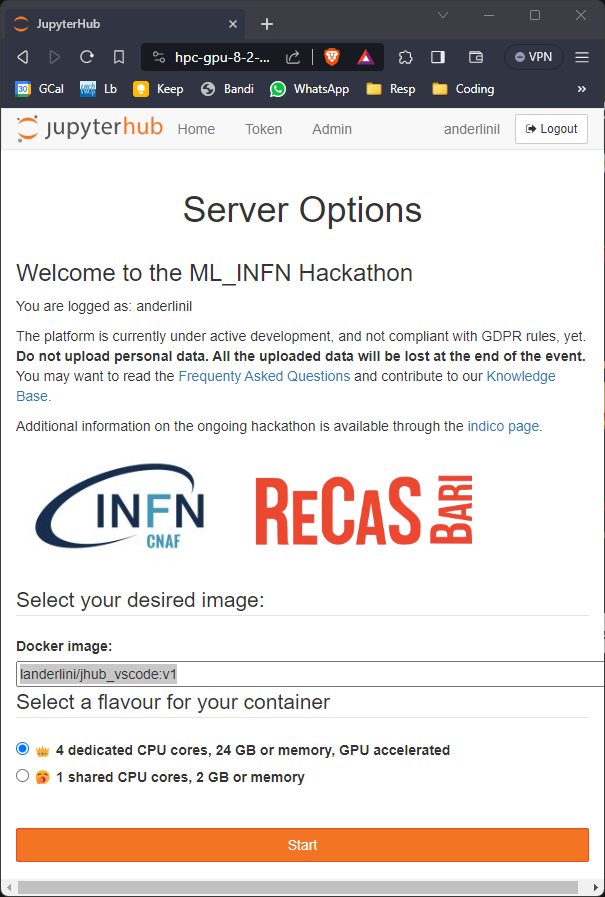

and spawn the new container!

If your image is too large, it may take a bit too long to get pulled from DockerHub and you may get an error like this:

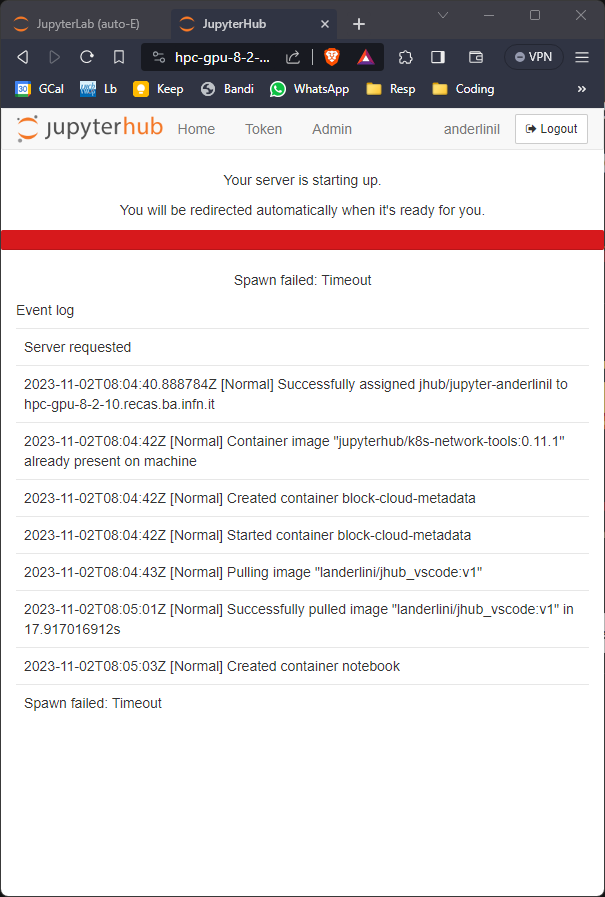

Even if the spawning fails, the image download continues in background. Wait some times for it to complete, and try again.

### Enjoy...
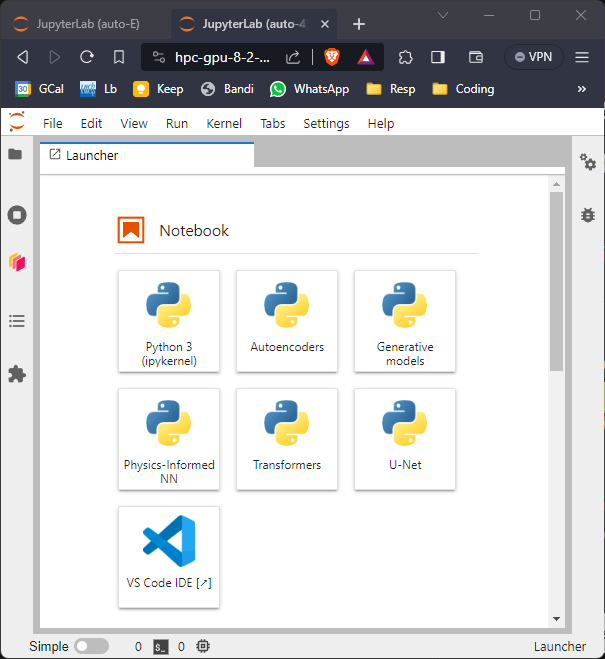

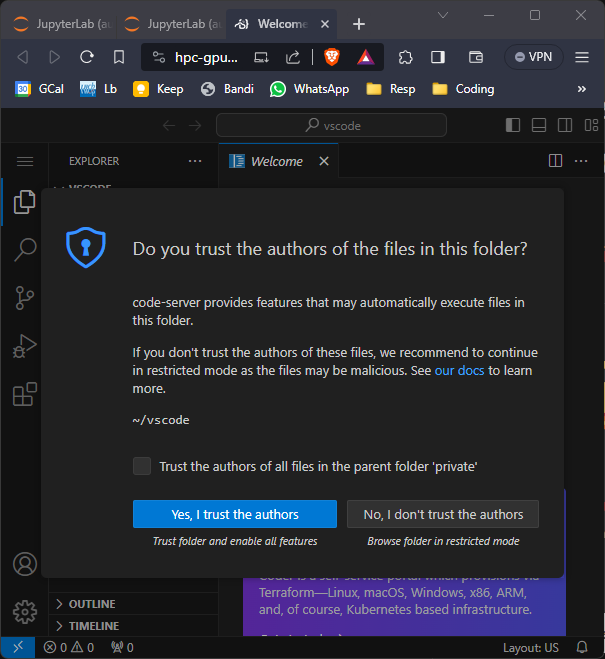


# Conclusion

In this *infrastructure hands-on* we have discussed how to customize the development environment.

In particular, we discussed:
 * how to create custom conda environments in the user space and how to install the kernel in JupyterHub
 * how to create a custom Docker image, possibly modifying the configuration of the JupyterLab instance itself, push it on DockerHub and customize the user experience adding third-party web applications.
 
As examples, we have installed TensorBoard, serving it through a Jupyter Proxy and we have installed VS code inside the Docker image.
The approach, however, is much more general, and a vast amount of web-based applications can be run the same way. 

Some notable examples you may want to explore:
 * [pgAdmin4](https://www.pgadmin.org/) a graphical user interface to configure and setup PostgreSQL databases;
 * [OpenRefine](https://openrefine.org/) a dashboard for interactive data visualization and cleaning;
 * [HedgeDoc](https://hedgedoc.org/) a web application for writing notes and documents in markdown;
 * [MLFlow](https://mlflow.org/) a web application with http APIs for tracking machine learning experiments.
 
You can also develop your custom web application, check the [StreamLit project](https://streamlit.io/) to get started.

The customization opportunities are almost endless, but they come with an important limitation you should be aware of:

**All the services and applications you setup within Jupyter are only accessible for a single user, behind an authentication layer, so they are not meant as collaborative tools or services.** 

If you plan to develop a collaborative tool, that has security, maintenance and authentication implications: you are moving out of the ML_INFN domain and entering DataCloud, get in touch and let's discuss how to move forward on a case-by-case basis!